В данном ноутбуке простое простой EDA

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from subprocess import check_output

In [2]:
!ls ../data/input

aisles.csv                order_products__train.csv sample_submission.csv
departments.csv           orders.csv
order_products__prior.csv products.csv


согласно https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b

`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`deptartments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)

загружаем файлы

In [3]:
order_products_train_df = pd.read_csv("../data/input/order_products__train.csv")
order_products_prior_df = pd.read_csv("../data/input/order_products__prior.csv")
orders_df = pd.read_csv("../data/input/orders.csv")
products_df = pd.read_csv("../data/input/products.csv")
aisles_df = pd.read_csv("../data/input/aisles.csv")
departments_df = pd.read_csv("../data/input/departments.csv")

нам даются данные о заказах, т.е. в какое время заказы были сделаны, к какой группе пользователей относится пользователь
существует 3 группы заказов:
- prior, первоначальная часть заказов, которые даны нам для обучения
- train, которые следует использовать для обучения
- test, которые для тестирования в соревновании

в заказе уже более подробная информация о заказанных позициях

In [4]:
print(orders_df.shape)
orders_df.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
print(order_products_prior_df.shape)
order_products_prior_df.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
print(order_products_train_df.shape)
order_products_train_df.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
orders_df.groupby("eval_set")["user_id"].aggregate(lambda x: len(np.unique(x)))

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

Всего даны данные об 206209 покупателях. Из которых последняя покупка 131209 покупателей дана как обучающая выборка и нам следуюет предсказать данные для оставшихся 75000 покупателей.

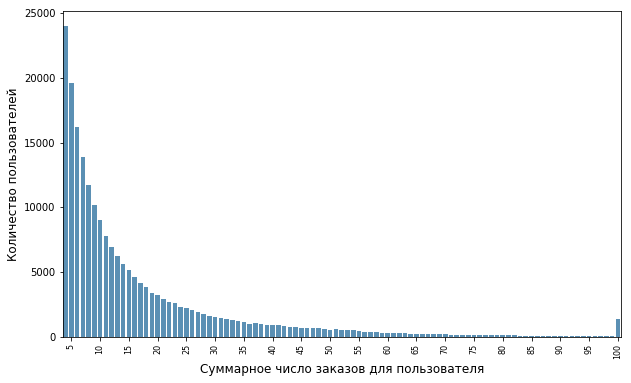

In [8]:
cnt = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt = cnt.order_number.value_counts()
cnt = cnt.reset_index(name='freq').rename(columns = {'index': 'count'}).applymap(int).sort_values('count')

plt.figure(figsize=(10, 6))
sns.barplot(cnt['count'], cnt['freq'], alpha=0.8, color=color[0])
plt.ylabel('Количество пользователей', fontsize=12)
plt.xlabel('Суммарное число заказов для пользователя', fontsize=12)
plt.xticks(rotation='vertical', fontsize=8, ticks = [n for n, x in enumerate(cnt['count']) if (x % 5) == 0],
          labels = [x for n, x in enumerate(cnt['count']) if x % 5 == 0])
plt.savefig('images/1_user_order_freq.png')
plt.show()

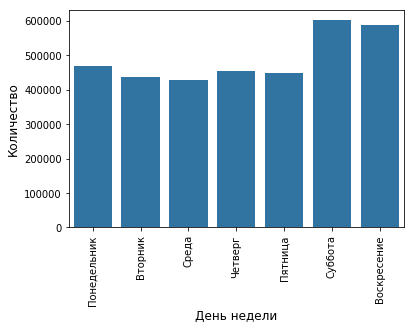

In [9]:
dow_df = orders_df[['order_dow']].copy()

dow_df.order_dow = [x - 2 if x > 1 else x + 5 for x in dow_df.order_dow]
dow_list = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресение']
dow_df.order_dow = [dow_list[x] for x in dow_df.order_dow]

plt.figure(figsize=(6,4))
sns.countplot(x="order_dow", data=dow_df, color=color[0], order = dow_list)
plt.ylabel('Количество', fontsize=12)
plt.xlabel('День недели', fontsize=12)
plt.xticks(rotation='vertical')
# plt.title("Количество покупок в зависимости от дня недели", fontsize=15)
plt.savefig('images/2_user_order_dow.png')
plt.show()

По всей видимости 0 и 1 - это суббота и воскресение, т.е. неделя стартует с субботы

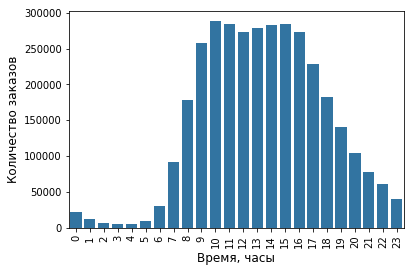

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[0])
plt.ylabel('Количество заказов', fontsize=12)
plt.xlabel('Время, часы', fontsize=12)
plt.xticks(rotation='vertical')
# plt.title("Количество заказов в зависимости от часа в течение дня", fontsize=15)
plt.savefig('images/3_user_order_hour.png')
plt.show()

По всей видимости заказы делаются в течение дня

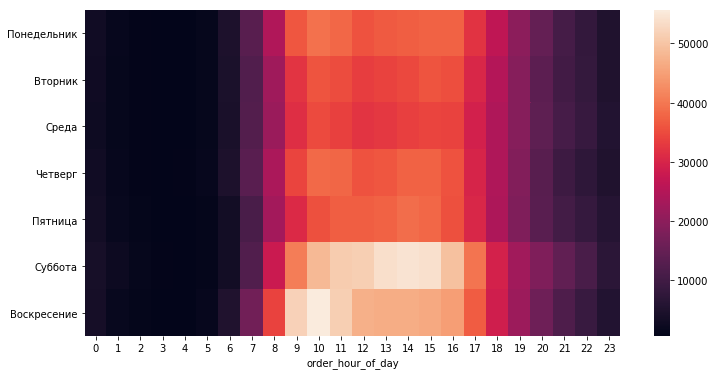

In [11]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')
grouped_df = pd.concat([grouped_df[2:], grouped_df[0:2]])
grouped_df.index = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресение']

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
#plt.title("Количество заказов в зависимости от дня недели и часа")
plt.savefig('images/4_user_order_hour_dow.png')
plt.show()

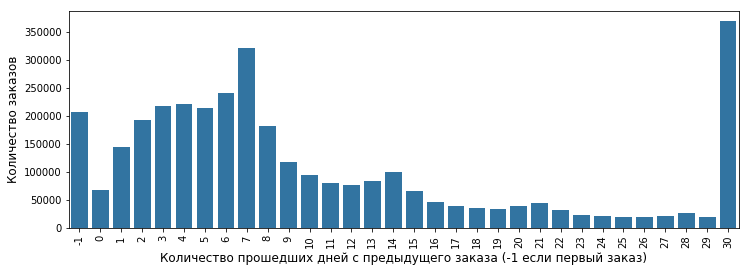

In [12]:
since_prior = orders_df[['days_since_prior_order']].copy()
since_prior.loc[since_prior['days_since_prior_order'].isnull(), :] = -1
since_prior = since_prior.applymap(int)

plt.figure(figsize=(12,4))
sns.countplot(x="days_since_prior_order", data=since_prior,
              color=color[0])
plt.ylabel('Количество заказов', fontsize=12)
plt.xlabel('Количество прошедших дней с предыдущего заказа (-1 если первый заказ)', fontsize=12)
plt.xticks(rotation='vertical')
#plt.title("Распределение по дням с предыдущего заказа", fontsize=15)
plt.savefig('images/5_order_count_vs_time_last_order.png')
plt.show()

По всей видимости покупатели заказывают либо несколько раз в неделю, либо с периодичностью в недели или 1-3 недели

Посчитаем долю предметов, которые являются повторными заказами

In [13]:
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.5896974667922161

In [14]:
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

В среднем, около 59% продуктов в заказе - это повторно заказанные продукты

In [15]:
def calc_reordered(df):
    df = df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
    df["reordered"].loc[df["reordered"] > 1] = 1
    return df.reordered.value_counts() / df.shape[0]

In [16]:
calc_reordered(order_products_prior_df)

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [17]:
calc_reordered(order_products_train_df)

1    0.93444
0    0.06556
Name: reordered, dtype: float64

около 12% заказов в наборе prior не имеют повторно заказываемых предметов, а в наборе train - 6.5%

Посмотрим на распределение по количеству продуктов в каждом заказе

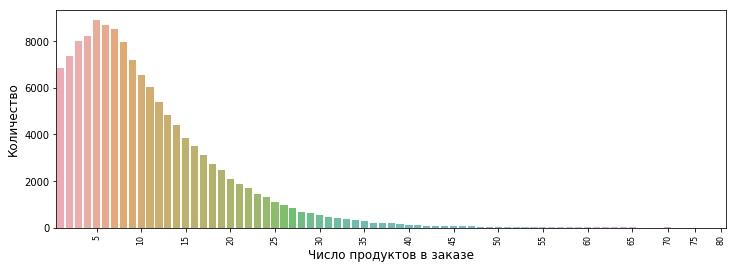

In [18]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()
cnt_srs = cnt_srs.reset_index(name='freq').rename(columns = {'index': 'count'}).applymap(int).sort_values('count')

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs['count'], cnt_srs['freq'], alpha=0.8)
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Число продуктов в заказе', fontsize=12)
plt.xticks(rotation='vertical', fontsize=8)
plt.xticks(rotation='vertical', fontsize=8, ticks = [n for n, x in enumerate(cnt_srs['count']) if (x % 5) == 0],
          labels = [x for n, x in enumerate(cnt['count']) if x % 5 == 0])
plt.savefig('images/6_num_products_in_order.png')
plt.show()

посмотрим на оставшиеся файлы

In [19]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [20]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [21]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


обьединим детали продуктов с order_prior

In [22]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


посмотрим на самые популярные продукты

In [23]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


в основном это скоропортящиеся продукты и фрукты, скорее всего из-за того, что их надо постоянно заказывать, а продукты длительного хранения - реже

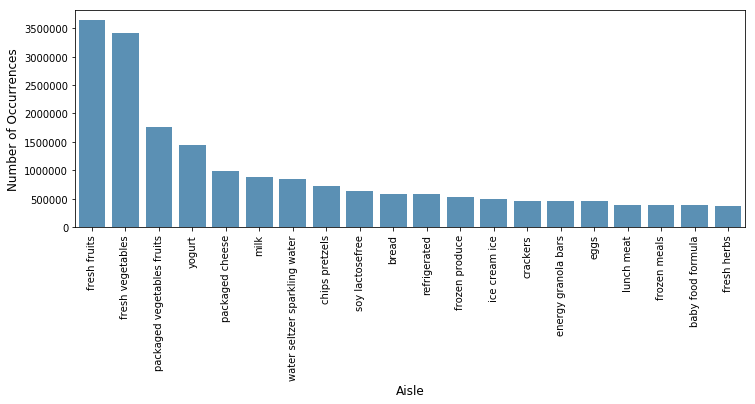

In [24]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

**посмотрим распределение по категориям**

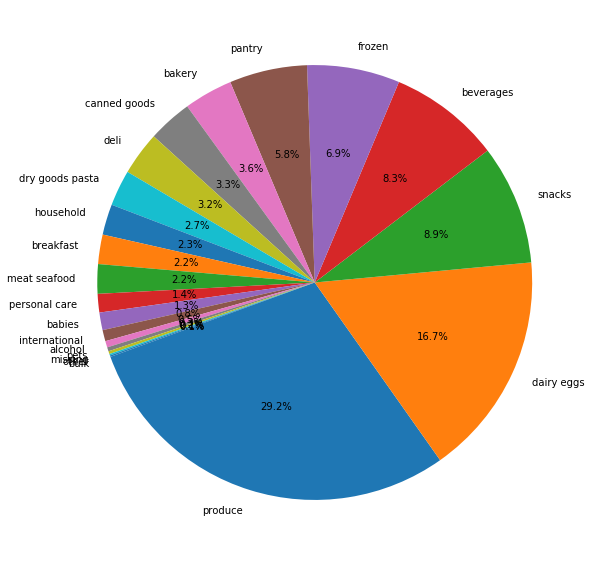

In [25]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
#plt.title("Departments distribution", fontsize=15)
plt.savefig('images/7_department_distribution.png')
plt.show()

Топ-5 самых популярных категорий: фрукты и овощи, молоко и яйца, снэки, напитки, замороженные продукты

Посмотрим на распределение доли повторных заказов по каждой категории

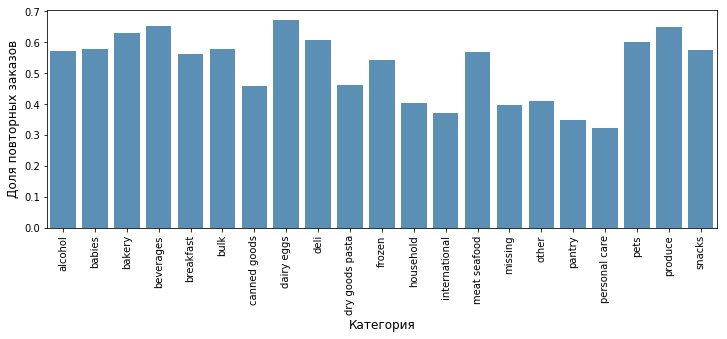

In [34]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,4))
sns.barplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[0])
plt.ylabel('Доля повторных заказов', fontsize=12)
plt.xlabel('Категория', fontsize=12)
#plt.title("Распределение доли повторных заказов в зависимости от категории продуктов", fontsize=15)
plt.xticks(rotation='vertical')
plt.savefig('images/8_reorder_vs_category.png')
plt.show()

Чаще всего повторно заказывают категорию молоко и яйца

**Повторные заказы в зависимости от подкатегории**

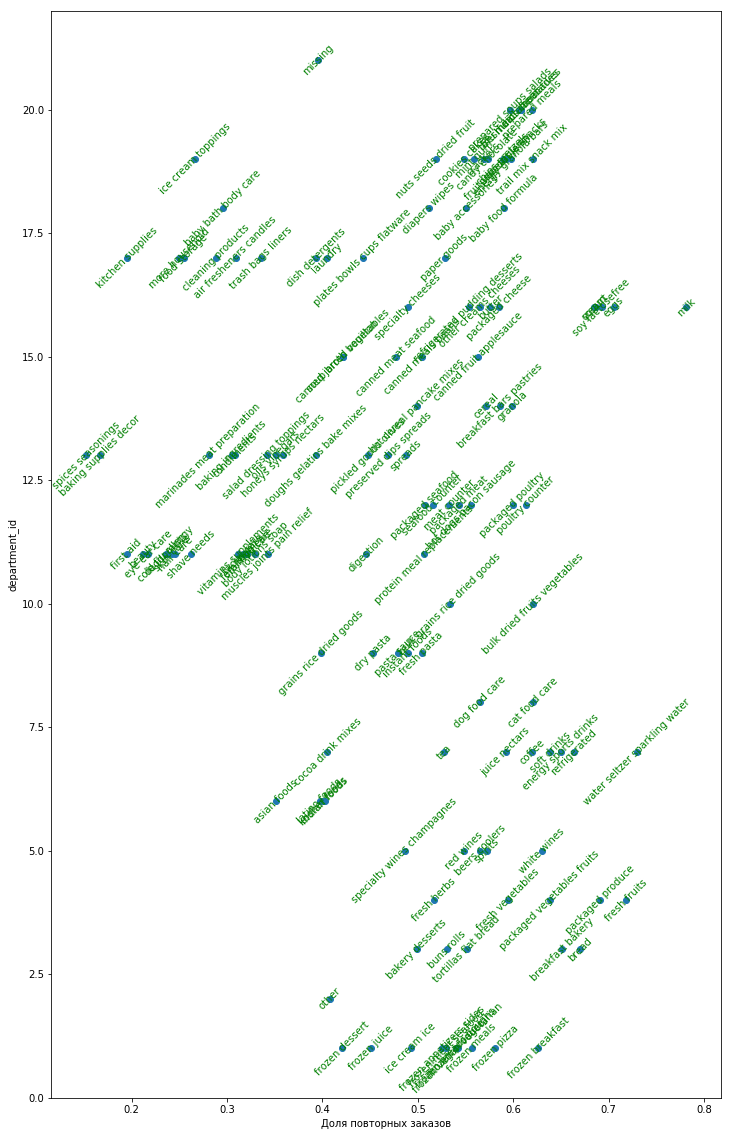

In [27]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Доля повторных заказов')
plt.ylabel('department_id')
#plt.title("Доля повторных заказов в зависимости от подкатегории", fontsize=15)
plt.show()

**Корзина - повторные заказы**

/Users/alex/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


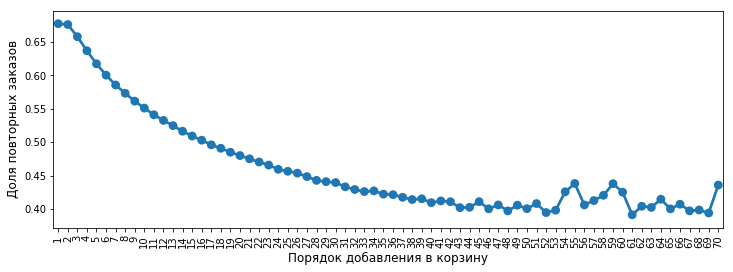

In [28]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].loc[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,4))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[0])
plt.ylabel('Доля повторных заказов', fontsize=12)
plt.xlabel('Порядок добавления в корзину', fontsize=12)
plt.xticks(rotation='vertical')
plt.savefig('images/9_cart_order_vs_reorder.png')
plt.show()

Как видно из графика, продукты, порядок добавления заказов в корзину влияет на повторные покупки, самые повторно заказываемые идут в начале корзины

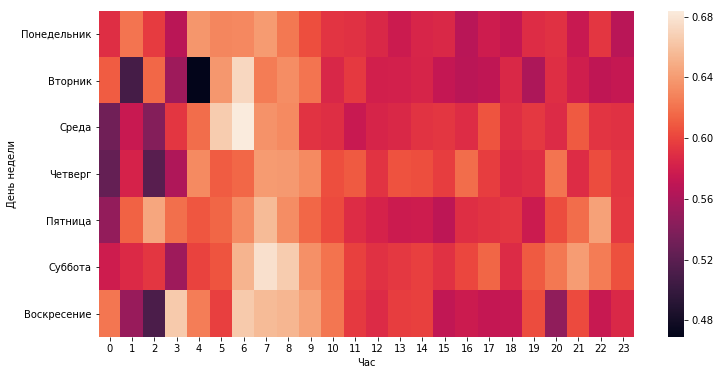

In [29]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')
grouped_df = pd.concat([grouped_df[2:], grouped_df[:2]])
grouped_df.index = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресение']

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.ylabel('День недели')
plt.xlabel('Час')
#plt.title("Доля повторных заказов в зависимости от дня недели и часа")
plt.savefig('images/10_reorder_vs_time.png')
plt.show()

Доля повторных заказов более высокая в утренние часы по сравнению со второй половиной дня.